# Test of GraphSAGE
- the version of 1 layer graphSAGE and node noise
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]

        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:0


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [4]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        g.ndata['feat'] = th.tensor(data["node_feat"])
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)


# def collate(samples):
#     data_list = samples
#     batched_graphs = []
#     for data in data_list:
#         g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

#         node_feat = th.tensor(data["node_feat"])

#         # 添加噪聲
#         noise = th.normal(mean=0, std=0.01, size=node_feat.shape, device=node_feat.device)
#         node_feat += noise

#         g.ndata['feat'] = node_feat
#         g.edata['feat'] = th.tensor(data["edge_attr"])
#         g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

#         batched_graphs.append(g)
    
#     return dgl.batch(batched_graphs)


In [5]:
datasets = ['repeat_train_320', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/repeat_train_320.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [6]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(64)

- Turn the print message to a log file

In [7]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transR_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1015_03:24_GraphSAGE_transR_50.log


### Model

In [8]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, out_dim, 'pool')
#         self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'pool')
#         self.dropout = nn.Dropout(0.25)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
#         h = self.dropout(h)
#         h = self.layer2(g, h)
        return h

In [9]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [10]:
class Model(nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [11]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 5000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [12]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [13]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.1415, -0.1232, -0.2210,  ..., -0.1132,  0.1040,  0.1068],
        [ 0.2094, -0.0312,  0.1230,  ..., -0.0153, -0.0057,  0.1573],
        [-0.1400,  0.2284, -0.0143,  ..., -0.1863, -0.2516, -0.1591],
        ...,
        [ 0.1911,  0.0178, -0.2430,  ..., -0.1795, -0.0926, -0.0837],
        [ 0.1862,  0.0516,  0.0851,  ...,  0.2165,  0.2184, -0.2323],
        [ 0.0705, -0.0225,  0.0456,  ..., -0.0348, -0.0728,  0.2025]],
       requires_grad=True)

- Check if model really load the model_dict

In [14]:
model = Model(in_features=50, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.1415, -0.1232, -0.2210,  ..., -0.1132,  0.1040,  0.1068],
        [ 0.2094, -0.0312,  0.1230,  ..., -0.0153, -0.0057,  0.1573],
        [-0.1400,  0.2284, -0.0143,  ..., -0.1863, -0.2516, -0.1591],
        ...,
        [ 0.1911,  0.0178, -0.2430,  ..., -0.1795, -0.0926, -0.0837],
        [ 0.1862,  0.0516,  0.0851,  ...,  0.2165,  0.2184, -0.2323],
        [ 0.0705, -0.0225,  0.0456,  ..., -0.0348, -0.0728,  0.2025]],
       requires_grad=True)

In [ ]:
import csv
import pandas as pd
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = GraphSAGE(in_dim=50, hidden_dim=16, out_dim=167)
model = Model(in_features=50, out_features=128, num_classes=167)
# in_dim means the dimension of the node_feat(50 dim, since the 50-dim embedding)
# out_dim means the # of the categories -> 168 for out tasks
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-8.pt"

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 50

# save the best model
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.


# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    for batched_g in tqdm(dataloaders['repeat_train_320'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
            
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

#         print(best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            add_log_msg("============================== Early stopping ==================================")
            break
            

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/13/2023, 02:43:47# labels of 5000: tensor([  2,  11, 152,  97,  75, 116, 124,  92, 164,  54,  14, 144, 112, 151,
         42, 124,  74, 104, 151, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154,  44,  42,  33,   9,  75,  75,  92, 124,   1,  54,  83,  11,  42,
         53,  30,  47,  34,  18,  53,  30,  57,   9, 163,  75,  87, 162,  18,
         44, 142,  74, 164, 124,  38,   1,  24, 143,  11, 151,  36, 143, 109,
         14,  42,  92], device='cuda:1') torch.Size([157])
10/13/2023, 02:43:47# predicted of 5000: tens

10/13/2023, 03:06:26# labels of 50000: tensor([ 74,   4, 121,  30,  33,  24,  38,  55, 125,  76, 109, 112, 104, 125,
         48, 143,  33, 121,  34,  75,   1, 144,  81, 111,  42,   4, 163,  36,
         12,  49,  57, 109,  36,  74, 125,  42,  83, 143,  18,  30,  38, 125,
        150, 104,  30,  54,   2, 152, 144, 116,  53,  92,  33,  44,  14,  36,
        125, 111,  83,   9, 119,  83,  49,  47], device='cuda:1') torch.Size([64])
10/13/2023, 03:06:26# predicted of 50000: tensor([  4, 158,  11, 158, 124,   4,  11, 158,   4,   2, 124, 124, 150, 125,
         31,  42,  31, 125, 125,  11, 124, 125,  38,  11,  11,  31, 158,  11,
        124, 125, 125, 158,  48,   4, 125,  11, 124,  11,  31, 125,   2, 125,
         42,  30,   2, 124,  38,  38, 158,   4,  12,  11, 125, 124,   4, 124,
         42,   4,  31,  38, 119,   4,  31,  11], device='cuda:1') torch.Size([64])
10/13/2023, 03:09:01# labels of 55000: tensor([164,  87,  31, 109,  47,  60, 119,  76,  34,  24, 119, 112,  36,  14,
         18,

10/13/2023, 03:32:30# labels of 95000: tensor([ 34,  47, 157, 162, 109,  76,  36,   4,  76, 125, 142,  44,  48, 143,
        150, 104,  31, 163, 164,  60,  42,  57,  11, 125, 124, 104,  31,  30,
        111, 158,  11, 104, 124,  18,  47,  74,  34,  11,  55, 152,  97, 125,
         11,  75,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  76,  55,  76, 158,
         51,  65,  65,  51,  51,  51,  51, 116, 150,   9, 151,   1,  34, 121,
        163,   4,  60,  18, 157,  75, 116], device='cuda:1') torch.Size([119])
10/13/2023, 03:32:30# predicted of 95000: tensor([ 14, 152, 142,  87, 162,  38,  14,  47,  54, 164,  14,  14, 164, 142,
         87,  81,  74,   2, 142, 157, 142,  74,   9, 164,  81, 152,  14, 125,
        124,  83, 142,  75,  14, 164, 104,  24, 125, 142, 16

10/13/2023, 03:53:00# labels of 135000: tensor([151, 157,  57,  48, 164,  97,  54,  18,  74,  11,  92,  33, 164, 104,
         97,  36,  42,  76,  30,   4, 162,  44, 124, 152,  48, 151, 152,  92,
         83,  48, 119,   2, 143,  48,  24,  48, 164, 162,   2, 104, 151,  54,
         54, 163, 144, 150, 144,  57, 111,   9, 116,  60,   1,  24, 109, 144,
          2, 112,  76,  76,  87,  87, 133, 133, 133, 133, 133, 133, 133, 133,
        109], device='cuda:1') torch.Size([71])
10/13/2023, 03:53:00# predicted of 135000: tensor([ 36, 152, 104,  87,  75,  38,   4,  14,  38,  75, 162,  75, 124,  36,
        152,  38, 142,  55,  87,   4, 163,  38,  34, 142,  42, 152, 109,  38,
        142, 152,  38, 142,  18, 142,  75,  87, 142,  75,  42,  38, 150,  74,
          4, 142,  31, 109,  36, 152,  31,  31, 158,  75,  18,  38,  38,  36,
         75,   4,  83,  53,  34, 142, 133, 133, 133, 133, 133, 133, 133, 133,
         87], device='cuda:1') torch.Size([71])
10/13/2023, 03:55:32# labels of 140000: t

10/13/2023, 04:20:16# labels of 185000: tensor([ 53, 162, 124,  30, 124,  74, 119,  57, 163,  18, 112, 111,  34,  24,
        163,   1, 164, 151, 119,  81,   2, 150,  38,  34, 116,  24, 121,  54,
        143,  55,  83,  14,   1, 119, 121, 152,  55,  53, 150,   4,  57, 163,
         18,  14, 124, 163,  97, 124,  92, 104,  30,  30, 143,  11, 143,  18,
         60,  30, 157,  83,  38, 121,  48, 121], device='cuda:1') torch.Size([64])
10/13/2023, 04:20:16# predicted of 185000: tensor([ 48,  24,  44,  87, 121,  44, 151, 143,   4,  36,  42,   4,  24,  24,
         36,  36,  87,  34, 124,   4,   4,  12,  55, 124, 142,  12,  36, 150,
         24,  34,  36,  12,  24,   4,  24, 142,  12,  48, 142,  44, 162, 142,
        162,  44, 125, 142, 162,  12,  81,  44,  24,  36,  34,  36,  48,  87,
        124,   2, 164, 162,  74, 162, 124,  36], device='cuda:1') torch.Size([64])
10/13/2023, 04:22:48# labels of 190000: tensor([119, 111,  57, 119,  42,  49, 119, 157, 112,   4,  12, 143,  54, 164,
         

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 04:34:36# labels of Validation: tensor([ 88,  88,  64,  64, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134,  65,  65, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  56,  56,
         56,  56,  56,  56, 152, 145, 145, 145, 145, 145, 145, 131, 131, 131,
        131, 131,  51,  65,  51,  51,  51,  51,  43,  43,  96,  96,  96,  96,
         96,  96, 110, 110, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123,   2, 111,  97, 113, 113,  13,  13,  13,  13,
         13,  78,  78,  78,  78,  78, 107, 107, 107, 107, 107, 107, 107, 107,
         75,  65,  65,  65,  65,  65, 135, 135, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
         71,  71,  7

10/13/2023, 04:34:45# Validation Loss: 0.3209 | Validation Accuracy: 0.9501

10/13/2023, 04:34:45# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/13/2023, 04:37:19# labels of 5000: tensor([ 31,  11, 111, 151,  11,  97,   4, 125, 157,   1,  83,  57,  83, 104,
        163,   9, 142,  48,   4, 162, 143,  76, 116,  33,  54, 164, 144, 116,
         12,  33, 143,  54,  55,  60,  34,   1,  11, 143, 112, 158,  18,   9,
         42,  74,  83,  97,  74,  97, 121,   1,  24, 158,  60,   2,  31,  36,
          9,   4, 143, 144,  53,   4,   2, 144], device='cuda:1') torch.Size([64])
10/13/2023, 04:37:19# predicted of 5000: tensor([151, 142,  81,  42, 109,  60,  81,  60, 142,  81,  53,  60,  54, 142,
         60,  81, 151,  75,  81,  34, 109,  60,  81, 109,  87,   2,  42,  54,
        151,  24,  34,  11,   1, 142,  75,  81, 157,  81,  44,  74,   2,  81,
         53,  81, 104, 112,  54,  81,  81, 142, 162, 116,  31, 151,  81,  48,
        142, 151,  54, 151, 112,  92,  75,  92], device='cuda:1') torch.Size([64])
10/13/2023, 04:39:49# labels of 10000: tensor([ 83,  76, 109, 111,  60,  38,  34, 119,  24,   4,   4,  97,  12,  38,
         11,  

10/13/2023, 05:04:27# labels of 55000: tensor([ 97,  81,  75, 142, 124,  54,  24,  38, 116, 104,  76,  74,  31,  75,
         14,   2,   9,  81,  34, 121,   2, 112, 151, 125,  83, 151,  44,  24,
         34, 119, 150,  75,  42, 121,  31,  36,  81,  31,   2, 144, 157,  30,
         83, 157,  97, 124,  38,  53, 124, 150,  34,  92,  48, 162,   1,   2,
         11,  18,  42, 143,  60,  74, 163,  81], device='cuda:1') torch.Size([64])
10/13/2023, 05:04:27# predicted of 55000: tensor([ 83, 157,  76,   2,  14, 144,   4,  75,  76,  81,   2,   4,  11,  76,
        121,  33,  47, 157, 119, 112,  42,  34,  83, 144,  34,  38, 144, 144,
         55,  11,  76,  12, 142,  14,  87,  14, 144,  49,  44,  34,  76,   4,
         81, 144, 158,  81,  18,  14,  31,  76,  12, 158,  30, 142,  81,  12,
        144,  87,  18,   4,  42,  14,  81, 143], device='cuda:1') torch.Size([64])
10/13/2023, 05:06:58# labels of 60000: tensor([ 31,  44,   2, 111, 116, 109,   2, 109,  38,  92, 121,  30,  53,  49,
        109,

10/13/2023, 05:27:16# labels of 100000: tensor([ 18, 162, 152,  53, 104,  42,  47,  12, 143, 163,  44, 125,  14,  24,
         55, 121,  92,  11,  97,   1,  53,  55,  42, 158,  38,  97,   4, 143,
         60, 158,  75, 151,  57,  18,  49,  44, 124,  55,  38,  97,  47, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128,  54,  38,  48,   9,   9,  53,  57, 160, 160,
        160, 160, 160, 160, 160, 160,  42,   1,   2,  14,   1, 163,  34, 104,
        124, 158, 121, 111,  38,  92], device='cuda:1') torch.Size([90])
10/13/2023, 05:27:16# predicted of 100000: tensor([ 11,  54,   1,  14,  54,   1,  38,  54,  11,  42,  49, 125, 142,  38,
         38,  38,  53, 164, 162,   1,  60, 162, 142, 109,  11,  38,  54,   9,
        162,  83,  97,  87, 162,  36, 142, 162, 162,  54,  54, 142, 142, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128,  36,  38,  87,   1,  53,  75,  

10/13/2023, 05:42:36# labels of 130000: tensor([ 33, 150,  44,  57,  48,  38,  42,  33, 164,  42,   2,  18,   4, 162,
         44,   9,   1,  18, 124,   1, 109, 163,  34,  60,  18, 151, 158,  42,
          4, 157, 119, 124,  44, 112,  60,  12,  33,  83,  44, 112, 142,  48,
          4, 150,  57,  38, 144,  87,  49,  60,  34,   2,  57, 164,  36,  83,
        112,  24, 119, 111,  31,  42,  33,  76], device='cuda:1') torch.Size([64])
10/13/2023, 05:42:36# predicted of 130000: tensor([158,  47,  49,  12,  57, 121,  92,  47,  12, 157, 142, 150,  36,  31,
        164, 121, 121, 142,  83,  83,   2, 150, 150,  83, 150,  11,  18,  47,
         12, 142,  11,  75, 142,   2,  11, 150,  38, 143,  12,  11, 142, 157,
        142, 142,  11,  33, 124,  18,   9, 121,  55, 150,  53, 115, 150, 125,
         47,  12, 121,  31, 121,  53, 142,  11], device='cuda:1') torch.Size([64])
10/13/2023, 05:45:08# labels of 135000: tensor([116,  92,  33,  14,  76, 158,   9,  76,  11, 119, 104,  49, 125, 142,
        1

10/13/2023, 06:02:59# labels of 170000: tensor([ 47, 119,  75,  14,  12, 162,  24,  33,  55,  53,  34, 112, 111,  30,
         60,  83,  30,  55,  18,  44,  44,  38, 111,  74,  33,  76,  34,  92,
        125, 144,  30, 111,  74,  42, 124, 157, 116, 104, 109, 124,  12,  38,
         31,  42,  14,  18, 150,  53, 124,   9,  76,  11,  49,  49,  12,  42,
         18,  31,  11, 152,  87, 151,  12,  47], device='cuda:1') torch.Size([64])
10/13/2023, 06:02:59# predicted of 170000: tensor([ 87, 150,  44,  14, 158,  54,  60,  75, 162,  54,  34, 125,  75,  14,
        157, 119, 157,  54,  14,  33, 150, 150,  92,  33,  33, 109,  42,  14,
        150,  24, 119, 124,  36,  60, 125,  53, 150,  75,  75, 121, 158, 109,
         55,  33,  53, 157, 142, 150, 150, 116, 142,  48, 150,  14, 157,  81,
        121,  54,  42,  44,  60, 119, 150,   4], device='cuda:1') torch.Size([64])
10/13/2023, 06:05:32# labels of 175000: tensor([ 84,  84,  84,  84,  84,  84,  84,  84,  84,   1,  53, 162,  18, 164,
         

10/13/2023, 06:26:48# total batches: 213400
10/13/2023, 06:26:48# Epoch 1 | Train Loss: 3.7429 | Train Accuracy: 0.0835


Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 06:26:48# labels of Validation: tensor([19, 19, 19,  ..., 56, 56, 56], device='cuda:1') torch.Size([1654])
10/13/2023, 06:26:48# predicted of Validation: tensor([19, 19, 19,  ..., 56, 56, 56], device='cuda:1') torch.Size([1654])
10/13/2023, 06:26:48# labels of 0: tensor([19, 19, 19,  ..., 56, 56, 56], device='cuda:1') torch.Size([1654])
10/13/2023, 06:26:48# predicted of 0: tensor([19, 19, 19,  ..., 56, 56, 56], device='cuda:1') torch.Size([1654])
10/13/2023, 06:26:57# Validation Loss: 0.3307 | Validation Accuracy: 0.9489



Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/13/2023, 06:29:32# labels of 5000: tensor([104,  44, 116,  97, 151, 119, 152,  53, 111,  48,   9,  54,  57,  44,
        111, 162,  81,  97,  75,   9,  92,  18,  31,  24,  81, 125,  55, 163,
        164, 142,  31, 124,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
         28,  28, 163, 144, 104, 125,   4,  42,   9,  75, 116,  12, 143,  54,
         24,  31, 152, 124, 164,  97,  60,  97,  33, 144,  60,  44, 111,  11,
        109, 151,  49,  42,  53], device='cuda:1') torch.Size([75])
10/13/2023, 06:29:32# predicted of 5000: tensor([ 55, 125, 104, 158, 124, 143, 124, 124,  92,  47,  53, 125, 142,   4,
        119, 124,  92, 119,  92, 119,  92, 124,  87,  76,  31,  34, 124,  83,
        124,  24,  12, 164,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
         28,  28,  83,  75,  24, 164,  49,  60, 124, 109,  60,  34,  30,  24,
         47, 104,  55,  54, 150, 150,  92,  92,  14, 121,  14, 164, 124,  31,
        158,   4,  11,  87, 142], device='cuda:1') torch.Size([75])
10/13

10/13/2023, 06:54:59# labels of 55000: tensor([124,  34, 144,  87,  47,   4,   9,  57,  53,  97,  24,  24,   4, 125,
         11, 163,  31,  97,  38, 124,  36,  53,  83, 143, 124, 109,  31, 109,
         24,  53,  24,  11,  42, 109,  87,  14, 111,  60,  53, 142, 112,  34,
        111, 104,  74, 112,  49,  74,  53,  47, 144,  18,  30,  36,  55, 151,
         54,  53,  47,  30,  57, 119, 125,  87], device='cuda:1') torch.Size([64])
10/13/2023, 06:54:59# predicted of 55000: tensor([  9,  36,  60, 109, 157,  12, 109,  30, 116,  60,   9, 104, 119,  14,
         97, 158,  47,   9,  49,   1,  30,  33, 104,  74,  42,  33, 124, 142,
         42,   9,  55,  24,  92,  36,  81,  30,  48,   9, 104, 109,  12,  14,
          1,  60, 116, 142,  36,  33, 162,  57,  36,  14,  92,  33,  30,  31,
         12,  33,  60,  33,  33,  87,  36,  33], device='cuda:1') torch.Size([64])
10/13/2023, 06:59:26# labels of 60000: tensor([ 81,  60,  24, 116,   4, 164,  24, 124, 151, 164, 162, 112,  74,  38,
        143,

10/13/2023, 07:22:25# labels of 105000: tensor([ 36,  30, 158,  81,  14,  92,   1, 158, 111, 111, 116,  60,  87,  31,
        109,  81,  33,  97,  38,   9,  36,  47,  83,  11, 104,   9, 152,  76,
        151,  53, 121,  38, 157,  92, 124,  34,  57, 104,   9,  74, 151, 163,
        162, 125,  47,  83,  30,  38,  34, 142,  14, 121, 151,  11,  34,  36,
         42,  18,  42,  38,  87, 152,  49, 125], device='cuda:1') torch.Size([64])
10/13/2023, 07:22:25# predicted of 105000: tensor([151,  60,  57,  74,  47,  24,  30, 142, 142, 158,  57,  42,  30,  36,
        151, 142,  75,  47, 119,  47,  57, 142,  44,  12, 125,  53,  49, 163,
        143,  87, 158, 124,  60,  44,  57,  53, 121,  18,   2,  87,  47,  44,
         60,  60, 151,  38,  36,  30,  53,  44,  44, 125, 142, 164,   4,   2,
        143,  33,  14,  24,  18,  53, 151, 158], device='cuda:1') torch.Size([64])
10/13/2023, 07:24:59# labels of 110000: tensor([ 38,  36, 143,  24, 163,  44, 104,  44, 164,  54,  33,  76,   9, 109,
         

10/13/2023, 07:45:28# labels of 150000: tensor([151,  12,  11, 157, 111, 116, 104, 112, 111,  48, 157, 111, 124,  49,
        164,  30,  47,  81,  48,  44,   2, 143,  81,  55,  38,  33, 150, 163,
         83,  76, 151, 142,  14,  53,  83, 163,  24,  57, 109, 164,  31,  18,
         34,   9,  12, 164,  60,  53, 164,  24,  83,  33, 163,  48,   9,  87,
          1, 157,  81,  92, 121, 119, 144, 162], device='cuda:1') torch.Size([64])
10/13/2023, 07:45:28# predicted of 150000: tensor([ 11,  47,  24, 124,  53, 124,  18,   4,  14, 142,  14,  11,  14, 164,
         47, 125, 158,  92, 152,  47, 163, 158,  54, 104, 162,  83,  54, 116,
        125, 142, 112, 158,   4,  53,  49, 163, 158, 164, 158,  87,  47,  49,
         83,  60,  49, 104, 112, 163, 164,  54, 104, 142,  44,  51,  49,   1,
        125, 119,  14, 158, 119,  11, 143,  60], device='cuda:1') torch.Size([64])
10/13/2023, 07:48:03# labels of 155000: tensor([  9, 143,  34, 112,  14, 104,  87,  97,  36, 163, 152, 157, 152, 109,
         

10/13/2023, 08:11:12# labels of 200000: tensor([119, 109,  76,  11,  31,  92, 124, 112,  11,  12, 158, 162,  12, 125,
         18,  12, 124, 158,   1, 157, 121,   9,  31, 112, 124,  18, 121,  11,
        109, 111, 116, 121,  55,  47,  87, 109,  30, 162, 116,  44, 144,  36,
          4,  14, 125,   2,  38,  30,  33,  18, 124,  54, 121,  83,   4,  92,
         34,  83, 125,   1,  34,  24,  55, 124], device='cuda:1') torch.Size([64])
10/13/2023, 08:11:12# predicted of 200000: tensor([142, 121, 125, 112,  42,  60,  87,  14,  57,  30,  33,  48,   2, 152,
        142,  60, 119,  38,  31, 143,  38,  38,  87,  60,  24, 142,  54,  49,
          2,  49, 142, 162, 150,  38, 121,  60, 125,   4,  81,   2,  87,  14,
        109,  57,   2, 109, 109,  38, 124,   2, 119,  42,  24,  60, 152,  87,
         38,   1, 152,  11,  42,  33,  38,  38], device='cuda:1') torch.Size([64])
10/13/2023, 08:13:46# labels of 205000: tensor([150, 121, 116,  49,   2,  44,  42, 156, 156, 156, 156, 156, 156, 156,
        1

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 08:18:06# labels of Validation: tensor([162,  34,  65,  ..., 104, 157,  81], device='cuda:1') torch.Size([1430])
10/13/2023, 08:18:06# predicted of Validation: tensor([ 9, 75, 65,  ..., 42, 42, 42], device='cuda:1') torch.Size([1430])
10/13/2023, 08:18:06# labels of 0: tensor([162,  34,  65,  ..., 104, 157,  81], device='cuda:1') torch.Size([1430])
10/13/2023, 08:18:06# predicted of 0: tensor([ 9, 75, 65,  ..., 42, 42, 42], device='cuda:1') torch.Size([1430])
10/13/2023, 08:18:15# Validation Loss: 0.3294 | Validation Accuracy: 0.9495



Training:   0%|          | 0/213400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 08:40:25# labels of 40000: tensor([111,  81,  33,  12, 104,   2, 162, 163,  38,  57,  60, 119, 164,  74,
         87,  74, 125,   2,  55,  34,  18, 121, 152,  54, 109,  18,  54, 163,
         53,  81,  42,  33, 104, 109, 119,  18,  18, 104,  30,   1, 116, 163,
         49,   9,  44,  30, 121,  31, 121,   1,   9, 143,  14, 151,  42,  76,
        111, 162,  75, 151,  55,  34,  47,  75], device='cuda:1') torch.Size([64])
10/13/2023, 08:40:25# predicted of 40000: tensor([ 57, 124, 150, 142,  87,  42,  44, 125,   4, 125,  38,  81,  49, 104,
         87,  87, 142,  87, 124, 142, 150,   9, 157,  55,  11,   4,  11, 151,
         14,   9, 124, 157,  53,  36,  42,  11,   2,  14, 125,  14, 104,  53,
         42,   2,  47,  12,  48, 124, 124, 142,   9, 121,  87,  87, 157, 119,
         75,  38, 119, 121,  49, 119,  75,  87], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 08:43:01# labels of 45000: tensor([ 92,  34,  50,  50,  50,   1,  49,  74,  36, 125,  57, 111,  12,  97,
         38,   2,   4,  92,  18,  75, 124, 143,  31, 111, 150,  11,  31, 116,
         97, 150,  83,  60,  42,  81, 111,  97, 142,   1, 142,  42,  76, 119,
         34,  76,  76, 163,  76, 143, 162, 143,  81,   2, 124,  81,  74, 162,
        125,  11, 151, 150,  74,  57,  24, 158,  30, 116], device='cuda:1') torch.Size([66])
10/13/2023, 08:43:01# predicted of 45000: tensor([157, 162,  50,  50,  50, 163,  76, 142,  12,  81, 150,  87, 142, 150,
         33, 157,  75,  33,  74,   2,  14,   4,  12, 142,  14,  76,  34,  33,
          1,  57, 157,  31,  54,  18, 104, 142,  81,  74,  48, 121,  30,  30,
         55,  30, 164, 157,   9,  44, 144,  47,   1, 157, 157, 143, 151,  47,
         47,  47,  97,  57, 158,   9,  38, 164,  12, 158], device='cuda:1') torch.Size([66])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 08:50:41# labels of 60000: tensor([ 54, 152,  76,   9, 119, 121,  87,  81,  49,  47, 112,   4,  48, 142,
         57,  83,  76,  12,  53, 164, 162,  47, 150,   1,   9,  60,  11,  49,
        109,   2,  36,  33, 144, 143, 163, 125,  47, 121, 157,   4, 119,  60,
         27,  27,  27,  30, 162,  42,  18, 164,  14, 150, 157, 158, 116, 116,
        151, 143, 121,  42,  11, 104,  11,  60,   1,  14], device='cuda:1') torch.Size([66])
10/13/2023, 08:50:41# predicted of 60000: tensor([ 87,  42,  92, 152, 119,  83,  75,  34, 142,  83,  57,  83,   2,  55,
         75,  60,  75,   4,  57, 112, 119, 119,  42,  92, 164,  48,  83, 152,
         55,  49, 119,  83,  87,  92, 162, 109,  33, 143,  42,   2, 119,  34,
         27,  27,  27, 125, 119,  92, 142, 162,  54,  92,  83,  83,  83, 152,
        143,  14,  11, 152,  12, 150, 119,  34,  92,  12], device='cuda:1') torch.Size([66])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 09:05:30# labels of 85000: tensor([ 34,  92,   9,   1,  74, 164,  97,  38,  18, 109,  24, 152,  53, 125,
        124, 116,  11,   9,  49,  60,  55,  36,   2, 125,  14,  60,  44, 125,
         44,  74,   9,   1,  74,   1,  30,   2, 151,  87, 121,   1, 150,  97,
        151, 112, 109,  49,  36,  14,  87, 111, 125,   4, 150,  11,  38,  44,
         42, 158, 109,  60, 125, 158,  81,   1], device='cuda:1') torch.Size([64])
10/13/2023, 09:05:30# predicted of 85000: tensor([152,  24, 125, 111, 152,  14,  74,  12, 164,  12,   9,  42,  31,   4,
         32, 164,  47,  47,  97,  97, 112,  38,  97,  24,  38, 104,  60,  47,
         24,  38, 164,  60,  38,  24,  12,  38,  18,  33,   4,  14, 150, 111,
        143,  34,  75,  44, 152,  18,  97, 112,  55,  47,  44,  48, 124,  44,
         14,  47, 152,  92, 125,  97,  12, 163], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 09:13:18# labels of 100000: tensor([  9,   1,  75, 143, 109,  57, 144,  87,  44,  76,  11,  30, 163, 158,
         36, 143,  49,  97,   2, 142,  92, 125, 112,   1,  75,  18, 124,  74,
         30,  74,  34,  60,  75,  76,  83,   1,  81, 121,  54, 112,  36, 121,
        144, 158, 158,  53,  53, 119, 104, 111, 152, 121,  54, 162,  75, 164,
         49, 162,  31,  14,  92,  87, 116, 158], device='cuda:1') torch.Size([64])
10/13/2023, 09:13:18# predicted of 100000: tensor([ 92, 158,  18,  36,  31,  54,   1,  81,  60,  54,  31,  36,   4, 158,
         36, 150, 150,  75,  36,  34, 164,   1, 150, 150, 124, 109,  81,  36,
        158, 158, 150, 158,  36,  57,  97,  47, 152, 109, 104,  34, 150, 119,
         12,  18, 150, 158, 158, 150, 104,  75,  87, 152,  12,  47,  36,  55,
         34, 150,  33,  31,  47, 150, 150, 158], device='cuda:1') torch.Size([64])
10/13/2023, 09:15:51# labels of 105000: tensor([158, 113, 113, 164,  31,  80,  80,  80,  80,  80,  80,  44,  54,  38,
        1

10/13/2023, 09:39:04# labels of 150000: tensor([150, 125, 121,  30,  57,  11, 119,   1,  33,  74, 164,  55,  81,   9,
         30, 143,  74, 125, 150,  18, 112, 164,  14,  38, 164, 109, 104, 143,
         44,  11,  36,  18,  36,  48,  49,  55,  97, 111,  81,  12,  36, 142,
         33,  97, 163,  14,  36,  11, 150,  36, 104,  74,  42, 157,  55,  74,
         97, 158, 164,  54,  49,   9,  62,  62,  62,  62,  62,  62,  47],
       device='cuda:1') torch.Size([69])
10/13/2023, 09:39:04# predicted of 150000: tensor([ 30, 104,  55, 112,  11, 142,  49,  31, 158,  49,  53, 144, 112,   1,
         44,   4,  53, 104,  42,  60,  14,  55, 162,  92, 125,  31, 124, 164,
        150, 142,  49, 119,   2,  48, 152,  14, 124, 144,  60,  34, 142,   2,
        157,  60,  14,  83,  55, 104, 164, 152,  76, 142,  57, 157, 142,  31,
         55,   2,  31, 157, 125, 164,  62,  62,  62,  62,  62,  62,  60],
       device='cuda:1') torch.Size([69])
10/13/2023, 09:41:39# labels of 155000: tensor([ 11,  74,  34, 

10/13/2023, 10:05:16# labels of 200000: tensor([ 24,  83,  55,  92,  48,  92, 157, 164, 158,  44, 124, 150,  53,  33,
         76,   4, 162,  11,   2,  87, 144,   2,   1, 164, 144,   9,  18, 116,
         57,  13,  13,  13,  13,  13, 151, 104,  14, 104,  33, 109,  11,  55,
         31,  18,  81,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  49,   2,  92, 164,  36, 150, 152, 143, 163, 142,
         36, 150,  75, 152,  34,  83,  18,   9,   9,  42, 116,  34],
       device='cuda:1') torch.Size([82])
10/13/2023, 10:05:16# predicted of 200000: tensor([ 38,  36,  42, 150,  81,  53, 111,   2,   1,   2,  18, 163, 142, 142,
        119, 158,  36,  38,  42, 142,  83,  47,  47, 124, 142,   9, 119, 158,
        164,  13,  13,  13,  13,  13, 143, 116,  18,   9,   2,   4, 142,  12,
         14,  18,  33,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  83, 104,  18,  54,  18,  54, 109,  42, 119,   9,
         53, 124,  42,  33,

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 10:12:15# labels of Validation: tensor([101, 101, 101,  ..., 161, 161, 161], device='cuda:1') torch.Size([1021])
10/13/2023, 10:12:15# predicted of Validation: tensor([101, 101, 101,  ..., 161, 161, 161], device='cuda:1') torch.Size([1021])
10/13/2023, 10:12:15# labels of 0: tensor([101, 101, 101,  ..., 161, 161, 161], device='cuda:1') torch.Size([1021])
10/13/2023, 10:12:15# predicted of 0: tensor([101, 101, 101,  ..., 161, 161, 161], device='cuda:1') torch.Size([1021])
10/13/2023, 10:12:24# Validation Loss: 0.3184 | Validation Accuracy: 0.9502

10/13/2023, 10:12:24# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/13/2023, 10:15:06# labels of 5000: tensor([157,  48, 163,  49,   2,  31, 151, 104,  12,  54, 116, 150, 104, 124,
        152, 121,   1, 158, 152,  74,  30, 116,  42, 152, 157, 158, 143,  36,
         87,  24,  18, 109,  24,  34,   2, 143, 157,  18, 121, 109,   2,  18,
         18,  44,  49,   4,  87, 121,  54, 163,   9,  47,   2, 119,   4, 150,
        121,  18,   4,  34,  30, 151, 151,  75], device='cuda:1') torch.Size([64])
10/13/2023, 10:15:06# predicted of 5000: tensor([162,   9, 150,  42,  12,  57,   4, 164, 150,  36,  57,  92, 119,  31,
        152,  11, 119,  18, 104, 143,  57,  31,  42, 143, 164, 152,  12,  48,
         42,  36, 162,   2,  24, 124,  57, 142,  14,  31, 143,  75,  83,  24,
        144, 152,  31, 112, 128,  81, 118,  74, 143, 124,  14,  75, 124,  42,
         87,  14,  83,  14,  49, 111,  75, 142], device='cuda:1') torch.Size([64])
10/13/2023, 10:17:40# labels of 10000: tensor([ 97,  97,  47,  53, 125,  47,   4,   2, 163,   9,  18,  72,  72,  54,
         60,  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 10:37:26# labels of 45000: tensor([143,  74,  81, 124, 163,  30, 104, 150,   1, 125,   1, 121,  24, 151,
         57,   2,  87,  53,  49, 164,  48,   9, 158, 163, 116,  81, 119,  18,
        164,  54,   1,  64,  64,  18,   2, 109,  48,  60, 164,  92,  53,  76,
         14,  76, 125,  55,  57,  24,  87,  36, 104,  12,  49, 112,  48,  97,
        157, 109,  49,  30, 164,  48, 163,  34,  97], device='cuda:1') torch.Size([65])
10/13/2023, 10:37:26# predicted of 45000: tensor([121, 111,  75,   1, 152,  47,  24,  76,  55,  36,  44,  54,  87, 144,
         44,  87,   4,  31,  36,  54,   1,  74,  44, 162,  11,  11, 142, 145,
        151,  53, 158,  14,   9,  74, 157,  81,  49, 152, 152,  30,  49, 124,
         14, 124,  30,   1, 119, 162,  36,  31,  47,  12,   1,  87,  53, 142,
        142, 124,  12,  54,  87,  36, 157,  24, 119], device='cuda:1') torch.Size([65])
10/13/2023, 10:40:02# labels of 50000: tensor([ 76,  11,  14, 116,  48,  24,  34,  76,  76, 109,  49,  92,  14,  47,
  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 11:10:00# labels of 105000: tensor([119, 111, 162, 119, 124,  57, 164,  54,  54,  11,  44,  34,  34,  38,
         24, 104, 121,  14,  33, 121, 121,  11, 121, 111, 144,  55,  74,  11,
        157,  48,  14, 104, 157,  57,  76,  53,  55,  33, 152,  18,  47, 151,
         81,  33, 112, 144,  75, 164,  53, 143, 157,  60,  44,  76, 125,   4,
         11, 125, 104,   1, 162,  30,  87,  47], device='cuda:1') torch.Size([64])
10/13/2023, 11:10:00# predicted of 105000: tensor([ 87, 125,  74, 119,  34,  92, 121, 157, 104, 124,  54,   4,  47, 162,
         92,  11,  81, 111, 119, 142, 143, 111, 142, 121,  92,  34,  57,  31,
         48, 125, 112, 158, 124,  14,  97, 158, 119,  75,  48,  34,  42, 152,
         33, 111,   9,   9, 152, 162,  36, 119, 121,  12, 150, 124,  31,  14,
         42,  38, 162,   9,   2,  34,  33,  55], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 11:30:37# labels of 145000: tensor([ 57, 162,  47, 164, 152,  42,  92,  48,  33,  38, 150, 142,   1,  57,
         12, 124, 119,  34, 162,  92, 162,  49,  18, 157,  54, 142,  11,  38,
        157, 158,  57, 112,  92,  60,  49,  47,  34,  31, 124,   4, 151,  75,
        124,  76, 124, 151, 143, 158,   1, 143, 143,  53, 157, 144,  24,  60,
        111,  60,  97, 104,  74,  36,  76,  53], device='cuda:1') torch.Size([64])
10/13/2023, 11:30:37# predicted of 145000: tensor([152, 164, 124,  74,  53,  30,  81, 142, 121,  11,  49,  87,  42,   2,
        164,   2,  30,  47,  31,   4, 124,  11, 109,  24,  44, 104,  18, 163,
        125,  53, 162,  74, 150,  14, 142, 164, 142, 158,  74,  14, 151,   4,
        124,  81,  14,  31,  12, 124,  92,  30,  12,  81, 125,  97,  18,  60,
        163,  42, 142,  18,  31, 124,  53,   9], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 11:33:12# labels of 150000: tensor([121,  83,  76, 121,   9, 119, 124, 151,  38,  81,  97,   9,  24, 163,
        125,  75, 144,  18, 124,  31,  11,  31,  34, 119, 109,  60,   9,  75,
        143,  12,  38,  34,  55,  74,  33,  24,  81,  60,  54,  74, 142,  31,
         38, 111,  74, 111, 143,  83,  12, 125, 104,  12,  83,  97,  38, 163,
         38,  48, 111, 150,  33,  38,  48, 162], device='cuda:1') torch.Size([64])
10/13/2023, 11:33:12# predicted of 150000: tensor([143, 142, 119,  42,  24,  87, 104,   4, 142,  18, 150,  18,  76,  24,
        142,   4,  54,  12,  81,  92,  92,  53, 162, 144, 158,  75,  44,  34,
          4, 104, 119, 142, 142, 150,  74,  60, 142, 125,  42,  11, 124, 109,
        116, 152,  11, 111,  42, 119, 124, 142,  11, 142,  57,  44,  48,  49,
        142, 163,  44,  60,  42,  54, 124, 164], device='cuda:1') torch.Size([64])
10/13/2023, 11:35:47# labels of 155000: tensor([ 30,  92, 163,  54, 152,  74,  11,  55, 124, 144,  24, 121,  49,  97,
         

10/13/2023, 11:56:31# labels of 195000: tensor([ 31,  18,  75, 112, 143, 143, 152,  14, 112, 163, 158, 164, 111,  83,
         75, 157,  54, 109,  47,  55,  74,  76, 152,  54,  74, 143, 104,   9,
        104,  76, 125,  83,  97,  97,  74,  55,   9, 157, 116, 124,  14,   9,
         11,  92,  11,  74,  92,  42,  42, 150,   9,  92,   9, 150, 158,  75,
        116, 157,   9, 151, 119, 163,  31,   9], device='cuda:1') torch.Size([64])
10/13/2023, 11:56:31# predicted of 195000: tensor([104,  31,  47, 104, 158, 124, 152,  60,  81,   2,  44,  12, 142,  60,
        150,  34,  44,  54,  92,  76, 109, 124,  57,  47,  18,  53,  31, 143,
         44, 116, 142, 104,  18, 109,  81,  33, 150, 124,  44,  18, 152,  92,
        142,  36,  60,  76,  60,  48, 104,  42,  36,  87,  44, 142,  42, 119,
         11, 162, 104, 152,  38,  47,  44,  11], device='cuda:1') torch.Size([64])
10/13/2023, 11:59:08# labels of 200000: tensor([ 47, 104,  54, 164,  57, 111,  54,  97,  53,  42,  60,  81, 111, 144,
         

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 12:06:17# labels of Validation: tensor([136, 136, 136,  ...,  23,  46,  46], device='cuda:1') torch.Size([1336])
10/13/2023, 12:06:17# predicted of Validation: tensor([136, 136, 136,  ...,  23,  46,  46], device='cuda:1') torch.Size([1336])
10/13/2023, 12:06:17# labels of 0: tensor([136, 136, 136,  ...,  23,  46,  46], device='cuda:1') torch.Size([1336])
10/13/2023, 12:06:17# predicted of 0: tensor([136, 136, 136,  ...,  23,  46,  46], device='cuda:1') torch.Size([1336])
10/13/2023, 12:06:26# Validation Loss: 0.3089 | Validation Accuracy: 0.9521

10/13/2023, 12:06:26# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/13/2023, 12:09:07# labels of 5000: tensor([ 30, 151, 116, 143,  24,  48,  34,  57,  75, 158,  53, 164,  34, 116,
         31, 152, 158, 144,  81,  83,  18,  57, 119,  48, 164,  18,  31, 163,
         12,  54,   9, 104, 162,  12,  36, 150, 151,  83, 144,  60,  54,  30,
         75, 144, 121,  75,  49,  38,  47,  87,   1,  55, 104, 142,  53,  53,
        152,  14,  49,  54, 111, 109,  42,   2], device='cuda:1') torch.Size([64])
10/13/2023, 12:09:07# predicted of 5000: tensor([116, 162, 111,  24,   4,  32,  87, 142,  38,  55,  49,  47,  60,  34,
        164,  34,   4,  55,  31, 121,  74, 119,  87, 119,   2, 104,  34,  30,
        104, 162, 124,   4,  36,  42,  11, 112,  55,  48,  36,  60,   4, 142,
        104,  34, 119,  47,  42, 142, 104, 125,  53,  42,  87, 104,  87,  57,
         33,   4, 150,  47, 124,   2,  92, 142], device='cuda:1') torch.Size([64])
10/13/2023, 12:11:50# labels of 10000: tensor([ 53, 164,  49,  14, 144, 111, 124,  47, 163,  87,  48, 164,  44, 116,
        104, 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 12:34:30# labels of 50000: tensor([111,  53,  87,  54,  30,  18,  31,  81, 112,  60, 119,  34,  44, 163,
        157, 144,  54, 164,  76,  53, 125,  30,  34,  53, 162, 109,  30,  83,
         44, 109, 116,   1,   9,  49, 142,   9,   9, 143, 151,  24,  33,  33,
         38,  87,  31,  11,  36, 162,  18,  33,  48,  44,   1,  57, 151,  24,
        157, 151, 150,  57,  18,  14,  34,  54], device='cuda:1') torch.Size([64])
10/13/2023, 12:34:30# predicted of 50000: tensor([ 36,  47,  55,   2,  31,  60, 142, 125, 142,  97, 125,  11, 124,  42,
        124,  42, 119,   4,  42,  11, 121,  55, 124, 109,  14,  44,   2, 142,
         49,  34,  36,   1,  49, 124,  38, 104, 142,  42,  31, 152,  38,  74,
        162, 125,  33,  42,  75,  12, 142, 150,  87,  55,  42, 142,  42, 162,
        150, 158, 142,  42, 142, 158, 142, 119], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 13:23:17# labels of 140000: tensor([ 38,  34,  55,  44, 151, 152,  33,  31,  44, 157, 157, 152,  18,  12,
         18, 158,  81,  57,  30,  76,  38, 111,  74, 157,  44,  14, 125,  44,
         42,  76,  92,  14,  12,  57, 116,  81,  49, 151,  24,  31,  81,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
         38,  74,   9,  14, 163,   2,  54,  42,  97,  33,  47,  53, 121, 116,
         44,  54, 150,  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 13:33:43# labels of 160000: tensor([158,  97,  24,   2,  55, 124, 164,  30,  34,  87,  87, 116,  60, 151,
        157,  83, 111, 143, 125, 143, 157,  92,   9,  14,  87,  83,  55, 116,
        112, 121,  31,  57,  60, 125, 164,  28,  28,  28,  28,  28,  65,  28,
         28,  28,  28,  28,  28,  28, 157, 163,  83,  48,  42,   1, 109,  33,
        144,  74,   1,  34, 152,  57,  42,  42, 151,   9,  34,  53,  55,  54,
        143, 158,  38, 137, 137, 137, 137, 137, 162,  14], device='cuda:1') torch.Size([80])
10/13/2023, 13:33:43# predicted of 160000: tensor([162,  42,  18, 152,   2,  75, 157,  60,  12,  38,   4, 142,  31,  33,
        157, 124,  48,  87, 142,  92,  55,   2,  30,  53, 162, 158,  55, 142,
        112,  34, 162, 119,  34, 119, 125,  28,  28,  28,  28,  28,  65,  28,
         28,  28,  28,  28,  28,  28, 142,  55, 142, 142,  42, 142,  87, 124,
        146,  87, 152, 119,  31, 111, 142,  31,  36,  47,  24, 162,  87,  47,
        142,  36, 158, 137, 137, 137, 137, 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 13:44:17# labels of 180000: tensor([124,  55, 152,  33,  44,  97, 109,   1, 119,   1, 142,  57,  47,   9,
         92, 162,   1, 142, 163,   4, 164,  11,  74, 116, 112, 112,  12,   2,
         36,  76, 158, 143,  42,  54,  31,  18, 157,  18, 143,  74, 164,  44,
         38, 112, 116,  42,  54,  44,  14, 164,  14,  11,  54, 119, 124,  97,
         31,  42, 116, 109,  11, 124, 158,  12], device='cuda:1') torch.Size([64])
10/13/2023, 13:44:17# predicted of 180000: tensor([ 34, 109, 142,  42,  57,  30, 142, 116,   2, 119, 116,  31,  55,  55,
         53,  60,  11, 164, 150,  49, 162,  42,  75,  44,  87,  87,  33,   4,
         42,  38,  47, 164,  57, 124,  42,  30,  12,  42,  31,  87,  42,  47,
          2,  38, 111,  42,  53, 119,  42,  31, 125,  60,  87,  92,  33,   4,
         33, 111, 116,  31, 125, 104,   4,  34], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 13:46:53# labels of 185000: tensor([ 24,   2, 151,  92,  34,  48,  12, 150,  49,  75,  97, 121,  18,   4,
          2,  49,  76,   2,  24, 119, 121,  49, 163,  33, 125, 121, 150,  81,
        150, 157,  74,  60, 142, 150,  24,  14,  33,  81, 111,  74, 125,  38,
         18,  81,  33,  76,  31,  42, 144,  53, 142,  54, 111,  87, 151,  47,
        119,  36,  92,  24,  33,  55,  44, 164], device='cuda:1') torch.Size([64])
10/13/2023, 13:46:53# predicted of 185000: tensor([ 12,   5,  87, 142,  31, 144, 121, 162, 143, 152,  42,  14,  34,  53,
        142,  24,   4, 162, 152, 112,  33,  14,  30, 142,  42,  57,  31, 121,
         34,  36,  42,  55, 142,  34,  55,  34,  75, 162, 158,  47,  87,  42,
        152,  31, 104,  34,  34,  42,  55,  24,  60,  24,  34,  31, 109,  30,
         60, 112, 142, 142, 143,  31, 157, 144], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 13:52:07# labels of 195000: tensor([109, 158, 121,  38, 104,  36,  74,  44,  24,  49, 151,  81, 152,  60,
         54, 116,  12, 111,   1, 164,  18,  97,  14, 150, 109, 125, 104,  31,
         34,  81, 119, 150,  10,  10,  97,  30, 144, 116,  97,  12, 150,   1,
        119,  33, 124, 163, 162, 112, 116,  60, 143, 152,  11,  49, 142, 163,
         87, 158, 162,  49,  44, 150,  49, 157, 152], device='cuda:1') torch.Size([65])
10/13/2023, 13:52:07# predicted of 195000: tensor([142, 142,  87, 125, 142,  12,  75,  42,  57, 142,  14,  76,  47,  31,
        119,  47,  54,  74,  87, 124,  87, 162, 104,  38,  92, 124, 125,   2,
         87,  42, 111, 109,  10,  10, 112,  42,  18,   4, 143, 142, 125,  42,
         92, 144, 143, 164,  42,  42,  33, 150, 144,   2, 142,  34,  57, 144,
         87,  42, 142,  55,  97, 124, 150,  55,  38], device='cuda:1') torch.Size([65])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 14:01:53# total batches: 213400
10/13/2023, 14:01:53# Epoch 5 | Train Loss: 3.7338 | Train Accuracy: 0.0863


Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 14:01:53# labels of Validation: tensor([142, 137, 137,  ..., 128, 128, 150], device='cuda:1') torch.Size([1862])
10/13/2023, 14:01:53# predicted of Validation: tensor([ 75, 137, 137,  ..., 128, 128, 144], device='cuda:1') torch.Size([1862])
10/13/2023, 14:01:53# labels of 0: tensor([142, 137, 137,  ..., 128, 128, 150], device='cuda:1') torch.Size([1862])
10/13/2023, 14:01:53# predicted of 0: tensor([ 75, 137, 137,  ..., 128, 128, 144], device='cuda:1') torch.Size([1862])
10/13/2023, 14:02:03# Validation Loss: 0.3162 | Validation Accuracy: 0.9513



Training:   0%|          | 0/213400 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 14:12:46# labels of 20000: tensor([157,  55, 109,   1, 164, 125, 112,   2, 150,  75, 157, 116, 116,  33,
         48, 162,  74,  33, 150,  92,  48, 111,   9,  57, 157, 152, 144, 150,
          9,  24,  33,  11,  36, 124, 158, 144, 124, 116,  76,  83, 164, 109,
        109, 124, 143,  81, 109, 111,  11,  97,  74,  42,   4,  12,  57, 150,
          9, 164, 104, 125,  88,  88, 121, 157,   9], device='cuda:1') torch.Size([65])
10/13/2023, 14:12:46# predicted of 20000: tensor([ 81, 152,  75,   2,   4,  74,  11,  14, 142,  75,  24,  24,  14,  11,
        119, 152,  81, 121,  53, 158, 164, 124,  75,  48,  14,  75, 124,   4,
         14,   4, 144,  75,  14, 124,  11,  33, 158, 119, 164, 125,  60,  47,
          2, 142,  42,  24, 152,  53,  38, 164, 120,  87,   4, 150, 143,  38,
          9, 162, 162, 124,  44,  44,   2,  42,  75], device='cuda:1') torch.Size([65])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 14:27:49# labels of 45000: tensor([ 14,  49, 124,  76,  53, 121,  48,  18,   9,  30,  76,  60,   2,  31,
         54,  54, 143, 121,  36,  48,  83,  31,  38,  33,  34,   1,  48,  48,
        164, 112,  47, 111,  12, 157,   4, 116,  92, 109,  81, 162, 109, 125,
         76, 164,  57,  48, 144,  76,  33,  54,   1,  38,  24, 158,  12,  55,
         74, 162,  11,  48,  12, 111,  31,  11], device='cuda:1') torch.Size([64])
10/13/2023, 14:27:49# predicted of 45000: tensor([142,  24,  14, 143,  42,  38, 104,  49, 104,  75,  74,  44,  83, 124,
         57,  53, 124,  34, 143,  92, 142,  49, 152, 142,  55,  75,  42,  87,
        152,  81, 142,  53,  57, 142,  87, 150,  57,  34, 119, 143,  87,  14,
        109, 116,   2,  87,  31,  75, 119,  33,   4, 143, 142,  57,  74,  11,
        143,  55, 109,  33,  83, 143,  81, 124], device='cuda:1') torch.Size([64])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10/13/2023, 14:30:25# labels of 50000: tensor([162,  49, 116,  74,  38,  33, 150,  11, 116, 124,  14,  54,  12, 112,
        109,  60,  42,  34, 143,  14, 104, 143,  36, 124,  97, 151,  44, 142,
        164,  97, 125,  97, 119, 104,  76,  81,   9, 144,  55, 111,  14, 164,
         48, 164, 104, 164,  75,  11,  87,  54,  47, 157, 116, 143, 142, 157,
         81, 119,  14, 142,  74,  24, 163,  33], device='cuda:1') torch.Size([64])
10/13/2023, 14:30:25# predicted of 50000: tensor([ 36,   1,  38,  81, 124,  55, 125,   9,  55, 142,  81,  57, 162,  38,
         92, 157, 121,  24,  12,  74,  55,  83, 152, 152,  42,  87, 151,   4,
        124, 163, 157,   4,  47,  18,  55, 104,  42,  38,  49,  36,  54,  34,
        162,  33,  75, 121, 111,  42,   9, 150, 152,  30,  49,  30, 162,  87,
         87,  60, 150,  47, 123,  38, 125,  49], device='cuda:1') torch.Size([64])
10/13/2023, 14:33:02# labels of 55000: tensor([ 14, 125,  75, 162,   9,   1,  57,  44, 121,  49,  81,  38, 150, 144,
        162,

10/13/2023, 14:51:26# labels of 90000: tensor([ 14,  57, 125, 109,   1,  54,  83,  97,  54, 124,  97,  57, 111,  47,
        112, 121,  57,  55,  30,  81,  97,  54,   2,  47,  75, 104,  31,  49,
          9,  55,   9,   4,  14, 125,  54,  42,  53,  47, 143,  18, 112, 121,
         92,  38,   2,  30,  34,  12,  74,  33,  47,  49,  76,  75, 121, 157,
         11,  44, 152,  42,  36,  75,   1,   2], device='cuda:1') torch.Size([64])
10/13/2023, 14:51:26# predicted of 90000: tensor([ 44,  53,  54,  44,  53,   2,  11, 142, 121, 164,  44,   2,  81,  87,
         14,   4,  33, 151,  47,  81,  87, 150,  12, 142,  74,  18, 142,   1,
         47,   4, 164, 116,  92,  55,  47, 142,  47,  42,  31, 157,  42, 157,
        142, 152,  55,  30,  60, 119, 152, 104,  53, 125, 142, 125, 150,   9,
        142,  87, 152,  24, 104,  74,  34,  47], device='cuda:1') torch.Size([64])
10/13/2023, 14:54:07# labels of 95000: tensor([ 36,   9, 116,  55, 151,  34, 119,  48,  38,  83,  38, 125,  38, 116,
        164,

10/13/2023, 15:17:03# labels of 135000: tensor([151, 157, 163, 143,  30, 104, 158, 119,  18,  76, 163,  18,  49, 163,
        143,  87, 109, 144,  49, 124, 116, 109,  48,  87, 163, 125,   1, 109,
        150,  55, 163,  36,  44, 143,  12,  12,   9, 109, 121,  55,  19,  19,
         19,  19,  19, 104,  18, 121, 143,  97,  55,  33,  76, 116,  42, 163,
        150,  76,  57,   4, 112, 112, 152,   1,  53,  31, 144,  14],
       device='cuda:1') torch.Size([68])
10/13/2023, 15:17:03# predicted of 135000: tensor([ 42, 142,  34, 142, 109,   4, 142, 119,   2, 142,  55, 164,  31,  74,
        125, 142,  42,  77,  18,  97, 142, 164,  30, 125,  12, 121, 143, 112,
         92, 124,  81,  12,  75, 144, 104,  55,  38,  55, 124,  44,  19,  19,
         19,  19,  19, 125,  75, 152,  14, 157,  36, 143,  18,  12, 142, 142,
        162, 158, 142,  33,   2,  87,  31, 109, 144,  44,  87,  49],
       device='cuda:1') torch.Size([68])
10/13/2023, 15:19:42# labels of 140000: tensor([ 75,  44, 119,   4,  49, 

10/13/2023, 15:43:40# labels of 185000: tensor([ 75, 142, 111,  48,   2, 151,  34,  34,  92,   9, 164,  53,  48, 158,
         97,  53, 158,  44, 124,  74,  47,  36,  12,   1,  75,  12,  76,  81,
         38, 152,   9,  42, 157,  81, 119,  97,  57, 163,  44,  12, 109,  42,
        150, 150,  54, 104, 104, 125,  53,  14,  54,  55, 157,  12,   2,  14,
         92,  55,  44, 143,  30, 116,  81,  34], device='cuda:1') torch.Size([64])
10/13/2023, 15:43:40# predicted of 185000: tensor([ 47,  44,  12, 162,  57,  31,  34,  12,  12,   4, 162, 109, 158, 119,
         44,  31, 152, 150,  60, 142,  12, 162,  57,  44, 119,  30,  87, 119,
         33,   2,  12, 109,  12,   4,  12, 150,  44,  36, 128,  34,  36, 162,
        162, 119,  18,   9,  38,  49, 143, 158, 124,  87, 124,  87, 121, 109,
        121,  92, 150, 143,  44, 162, 150, 142], device='cuda:1') torch.Size([64])
10/13/2023, 15:46:18# labels of 190000: tensor([ 76, 152,  55, 143, 116, 164,  57,  76,  44, 162,  92,  34, 150,  55,
         

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 15:58:40# labels of Validation: tensor([113, 113,  65,  65,  65,  65,  65,  65,  65,  65,  65, 135, 135,  49,
        102, 102,  65,  46,  46, 151,  12, 122, 122, 122, 122, 122, 122, 122,
         83,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   5,   5,
          5, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        160, 160, 160, 160, 160, 160, 160, 160, 148, 148, 148, 148, 148, 148,
        148,   9,  24,  67,  67,  67,  67,  67,   5,   5,   5, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/13/2023, 15:58:50# Validation Loss: 0.3223 | Validation Accuracy: 0.9498



Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/13/2023, 16:01:31# labels of 5000: tensor([  9, 121, 164,  57,   2, 109,  34,  24, 124,  60,  97,  74,  55,  42,
         42,  53,  54,  83,  75, 104, 143,  48,  92,  60,  11, 125,  87, 111,
         30,  30,  76,  44, 143, 112, 111,  12,  81,  81, 144, 125,  34, 151,
          2,  12,  33,  53,  97, 116,  36,  54,   1,  74,  92, 111, 124, 109,
        164,  49,  53, 112,   9,  92, 124,  74], device='cuda:1') torch.Size([64])
10/13/2023, 16:01:31# predicted of 5000: tensor([150, 163,  81,   4,  42,  30, 151, 151, 124, 162,  55, 142,  42, 142,
         55,  24, 143,  92, 157, 162,  42, 142, 151,   2,  60,  42,  42, 158,
          4, 152, 152, 142, 151,  42,   9,   2,  42,  42,  38,   4, 162, 151,
        119,  75,  34,  81,  92,  42,  60,  55, 152,  42, 162,  55, 142,  81,
        152, 143, 151,  14, 162,  75, 152,  42], device='cuda:1') torch.Size([64])
10/13/2023, 16:04:08# labels of 10000: tensor([ 54,  92, 151,  44,  49,  11,  36,  11,  48,  18, 119,  57,  75,  92,
         33, 1

10/13/2023, 16:27:55# labels of 55000: tensor([163,  60, 109,  11,  31, 124, 150,  30,  33, 158, 142,  11,  11,  47,
        157, 121, 162,  11,  36, 119,  12, 124,  75,   4,  97, 143, 164, 121,
        119,  75,  81,  74,  60,  60,  47, 163,  14, 163,  60,  34,  83,  74,
        143,   1,   9,  33,  38,  42, 162, 151,  75,  54,   9,   9,  44,  75,
        109, 163,  87,  24,  24, 151,  57,  64,  64], device='cuda:1') torch.Size([65])
10/13/2023, 16:27:55# predicted of 55000: tensor([ 74,  14,  14,   4,   2,   2,   2,  36, 164,  60,   2,  30,  81, 163,
         57, 150, 142,  48,   2,  38, 150,  33,  14,   4, 150, 125, 104,  81,
        150,  14,  30,  87, 164,   2, 111, 109,  36,  14,  38,  81, 164,   2,
        119,  18,   2, 124,  30, 115, 124,   4,   2, 150, 142,  55,  54,  55,
         75, 157,  74,  55,  49, 150,  87, 119, 163], device='cuda:1') torch.Size([65])
10/13/2023, 16:30:37# labels of 60000: tensor([ 53, 125,  30, 124,  44, 116,  34,   1,  14,  38,  81, 109, 143, 125,
  

10/13/2023, 16:53:43# labels of 100000: tensor([ 57,  92,  47, 152,  92,  44,  24,  54,  57,  75,  49,  11,  14,   2,
         97,  54, 124, 144,  31, 162, 121, 121,  47,  33,  87,  18, 152,   9,
        125, 150, 143,  24,   4,   9,  92, 163,  57,  74, 163, 163,  31,  48,
         14,  76,  47, 124, 157, 125,  11,  42, 163,  31,  55, 119,   4,  76,
        116,  14,  76,  49,  11,   1,  48,  24], device='cuda:1') torch.Size([64])
10/13/2023, 16:53:43# predicted of 100000: tensor([124,  11, 152,  44,  48, 111,  60,  87,   1,  76,  60, 152,  42, 158,
         44,  38, 158,  42, 158,  11, 158, 125,  54,  24, 124,  42,  83,  75,
         18,  38,  38, 158, 124,   4,  75,  83, 157,  44, 125, 164, 111,  34,
         38, 158,  60,  87, 124,  31,  11, 109,   1, 158,  75, 158,  38, 163,
         38,  83,  54,  44, 158, 109, 124,  60], device='cuda:1') torch.Size([64])
10/13/2023, 16:56:20# labels of 105000: tensor([143,  49,  83, 157,  33,  33,  11, 116, 164, 158,  44, 162, 151,  14,
        1

10/13/2023, 17:15:09# labels of 140000: tensor([ 30,  18, 124,  81,  55, 142,  48,  34, 151,  92,  97, 164,  57, 162,
        125, 163,   4, 164, 158,  38,  24,  24, 151,  38,   1,  11, 144, 143,
         57, 116,  92,  75,  12,  47,  49,  57,  14,  12, 142, 151, 104,   4,
         92,  49,  12,  49,  14, 152, 164,  38,  47,  24, 109,  33,  55,  97,
         76,  18,   9,  49, 143,  12,  76,  44], device='cuda:1') torch.Size([64])
10/13/2023, 17:15:09# predicted of 140000: tensor([112, 150, 112,  55,  83, 143, 142, 163, 150,  33,  74, 164,  87,  74,
        150, 111,  87, 164,  49, 150, 109,  38,  42,  74,  38,   4, 150, 158,
        104,   9, 164, 128, 116, 150, 143,  47,  55, 158,  33, 150, 109,   4,
         49,  42,  54, 150, 150, 121,  87, 164,  33, 157,  81,  47,  55,  11,
         49, 164,  38, 142,  49,  33,  47, 164], device='cuda:1') torch.Size([64])
10/13/2023, 17:17:55# labels of 145000: tensor([ 42,   1, 109,  33,  34, 121,  34,   1,  87, 157, 163,  18,  57, 157,
         

10/13/2023, 17:41:26# labels of 185000: tensor([ 92,  87,  47,  44, 150,  11, 164,   1, 152,  30,  44,  49,  33, 163,
         42, 157, 164,  54,  12, 121, 150,  49,  44,   1,  74,   2,  34,  47,
         81,  55,  38,  38,  44, 142,   4,  74, 121,  83, 144,  92, 109, 162,
         33,  83,  47,  14,  81, 109, 116,  11, 162,  65,  65,  65,  65,  65,
         65,  65, 135, 135,  33,  75, 142,  12, 152,  49,  97,  54, 112, 116,
        158,  57], device='cuda:1') torch.Size([72])
10/13/2023, 17:41:26# predicted of 185000: tensor([ 36,  57,  92,  34,  33,  14, 158,  12,  60,  36,  44, 152, 142,  36,
         53,  34, 164,  31,  12,  49,  12, 152,  12,  12,  92,  47,  12, 150,
         87,  49,  34, 164, 121,  53,  36,   2,  14,  12,  47,  38,  57,  44,
         55, 142,  36,  49,  87,  11, 116, 151, 121,  65,  65,  65,  65,  65,
         65,  65, 135, 135, 151,  49, 142, 157,  12,  36,  44,  34,  54, 104,
         47,  53], device='cuda:1') torch.Size([72])
10/13/2023, 17:44:13# labels of

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/13/2023, 17:56:47# labels of Validation: tensor([7, 7, 7,  ..., 7, 7, 7], device='cuda:1') torch.Size([1173])
10/13/2023, 17:56:47# predicted of Validation: tensor([7, 7, 7,  ..., 7, 7, 7], device='cuda:1') torch.Size([1173])
10/13/2023, 17:56:47# labels of 0: tensor([7, 7, 7,  ..., 7, 7, 7], device='cuda:1') torch.Size([1173])
10/13/2023, 17:56:47# predicted of 0: tensor([7, 7, 7,  ..., 7, 7, 7], device='cuda:1') torch.Size([1173])
10/13/2023, 17:56:57# Validation Loss: 0.3106 | Validation Accuracy: 0.9519



Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/13/2023, 17:59:41# labels of 5000: tensor([ 36, 116,  38,  75,  74,  57,  87,  18,  44, 104, 116,  87, 116,  57,
         48,  87,  57, 164,  11, 143, 124, 111, 158,  31,  97,  18,  57, 143,
        158, 143, 121, 104,  47,  34,  81, 158,   4,  83,  55,  31,  83,  76,
        124,  55, 144, 119,  53,  30, 162, 164,  54, 163, 111, 143,   9, 124,
         14,  48,  36, 125,  76,   2, 121, 143], device='cuda:1') torch.Size([64])
10/13/2023, 17:59:41# predicted of 5000: tensor([ 18,  12,  60, 164,  53, 164, 164, 124, 157, 150,  92,  74,   4, 150,
         42,  38,  36, 124, 157,  11,  38,  11, 164, 124,  42,  11,  34,  57,
         11, 151, 162,  75,  31,  34,  18, 158,  36, 164, 124,  38,   1, 164,
         44,  31,  36,  42, 158,  33, 164,  24, 104,  57,  75, 112,  12,  16,
         92, 158,  74,  74,  12, 164,  38, 142], device='cuda:1') torch.Size([64])
10/13/2023, 18:02:31# labels of 10000: tensor([144, 151, 164,  14,  38, 150,  87,  33, 112,  92, 109,  48,  76,  24,
         24, 1

### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [18]:
import pandas as pd
from sklearn.metrics import classification_report

pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-8.pt'
model.load_state_dict(torch.load(pretrained_model_path))
criterion = nn.CrossEntropyLoss()

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transR_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transR_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")

Testing:   0%|          | 0/258 [00:00<?, ?it/s]

10/15/2023, 04:04:47# labels of Test: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([2718])
10/15/2023, 04:04:47# predicted of Test: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([2718])
10/15/2023, 04:04:47# labels of 0: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([2718])
10/15/2023, 04:04:47# predicted of 0: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([2718])
10/15/2023, 04:04:47# labels: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([2718])
10/15/2023, 04:04:47# predicted: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([2718])
10/15/2023, 04:04:54# Test Accuracy: 96.9274454253327 %





/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/15/2023, 04:05:24# report path: classification_report/classification_report-transR_50-graphSAGE-8.xlsx
10/15/2023, 04:05:24# label path: classification_report/mapped_true_predicted_labels-transR_50-graphSAGE-8.xlsx


/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/15/2023, 04:05:35# mapped_report:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00      6400
    T1003.001_35d92515122effdd73801c6ac3021da7       1.00      1.00      1.00       600
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00       500
    T1003.002_7fa4ea18694f2552547b65e23952cabb       1.00      1.00      1.00      1500
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.00      0.01      0.01       100
    T1003.003_f049b89533298c2d6cd37a940248b219       0.04      0.04      0.04       100
        T1003_18f31c311ac208802e88ab8d5af8603e       1.00      1.00      1.00       600
        T1007_9d03c91bdae5a80f17f89c987942b5a8       1.00      1.00      1.00       600
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.00      0.00      0.00       100
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.00      0.00      0.00     

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,1.000000,1.000000,1.000000,6400.000000
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,600.000000
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,500.000000
T1003.002_7fa4ea18694f2552547b65e23952cabb,1.000000,1.000000,1.000000,1500.000000
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.003937,0.010000,0.005650,100.000000
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,1.000000,1.000000,600.000000
benign,1.000000,1.000000,1.000000,134563.000000
accuracy,0.969274,0.969274,0.969274,0.969274
macro avg,0.590462,0.589665,0.586412,310263.000000


In [20]:
label_mapping

{0: 'T1003.001_35d92515122effdd73801c6ac3021da7',
 1: 'T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517',
 2: 'T1047_ac2764f7a67a9ce92b54e8e59b361838',
 3: 'T1059.001_6efbccc1869e8cd618c0d3ecda407d5f',
 4: 'T1078.001_d0ca00832890baa1d42322cf70fcab1a',
 5: 'T1112_257313a3c93e3bb7dfb60d6753b09e34',
 6: 'T1119_344e7eaf650763e0d3e9f02e62c1cf4b',
 7: 'T1219_7dabcbecab0334b115feefab1630f84a',
 8: 'T1562.004_280003641a5cddf916c4f2bf605a71d3',
 9: 'T1497.001_1258b063-27d6-489b-a677-4807faacf868',
 10: 'T1547.001_4b71ebb2f6f6a01235ba240fa40ce978',
 11: 'T1018_a44bb43474728496276d5d73aa14588f',
 12: 'T1047_b0255b5120cbabc062d8d4510a142c3b',
 13: 'T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2',
 14: 'T1082_29451844-9b76-4e16-a9ee-d6feab4b24db',
 15: 'T1112_34041639e6e501856ecaf5969ee29c76',
 16: 'T1119_7121cdf93b951311be9d7078c602efdc',
 17: 'T1219_af8cb2bf9b436aae5c106a0a9c207e14',
 18: 'T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81',
 19: 'T1003.002_5a484b65c247675e3b7ada4ba648d376',
 20: 'T1547.00

In [26]:
# # threshold = 0
# # filtered_report = report_df[report_df['f1-score'] == threshold]
# # print("Number of rows:", filtered_report.shape[0])

filtered_report = report_df[(report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score<=0.2:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]
num_rows = filtered_report.shape[0]
print("Number of support=200 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] > 200)]
num_rows = filtered_report.shape[0]
print("Number of support>200 and f1-score=0:", num_rows)

threshold = 0 
filtered_report = report_df[report_df['f1-score'] == threshold]
# print("Number of rows:", filtered_report.shape[0])


# filtered_report

Number of support=100: 54
Number of support=100 and f1-score<=0.2: 53
Number of support=100 and f1-score=0: 24
Number of support=200 and f1-score=0: 10
Number of support>200 and f1-score=0: 5


In [21]:
threshold = 0.2
filtered_report = report_df[report_df['f1-score'] <= threshold]

filtered_report

,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.003937,0.01,0.005650,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.035088,0.04,0.037383,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.000000,0.00,0.000000,100.0
T1007_d6bb2a19da7246731ed9c44831b135f8,0.000000,0.00,0.000000,300.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.000000,0.00,0.000000,100.0
...,...,...,...,...
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.000000,0.00,0.000000,200.0
T1562.004_5b93df032e230056c21a3e57334f77d1,0.000000,0.00,0.000000,100.0
T1562.004_8d0a4585e7c4646185a912b14cd9cb46,0.008065,0.01,0.008929,100.0
T1564.001_66a5fd5f244819181f074dd082a28905,0.000000,0.00,0.000000,500.0


In [22]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# # Print to check if the indices are what we expect
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]

# with open('triplets_1.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')


filtered_report

Number of rows: 24


,precision,recall,f1-score,support
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.0,0.0,0.0,100.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.0,0.0,0.0,100.0
T1033_c0da588f-79f0-4263-8998-7496b1a40596,0.0,0.0,0.0,100.0
T1047_b0255b5120cbabc062d8d4510a142c3b,0.0,0.0,0.0,100.0
T1047_f4b0b4129560ea66f9751275e82f6bab,0.0,0.0,0.0,100.0
T1049_638fb6bb-ba39-4285-93d1-7e4775b033a8,0.0,0.0,0.0,100.0
T1055.002_e5bcefee-262d-4568-a261-e8a20855ec81,0.0,0.0,0.0,100.0
T1057_5a39d7ed-45c9-4a79-b581-e5fb99e24f65,0.0,0.0,0.0,100.0
T1057_f8de05d1741dcc468f772ab0ff4dac72,0.0,0.0,0.0,100.0
T1078.001_d0ca00832890baa1d42322cf70fcab1a,0.0,0.0,0.0,100.0


In [23]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]
# print(mapped_labels)

# with open('triplets_2.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')

filtered_report

Number of rows: 10


,precision,recall,f1-score,support
T1036.004_1f0614ea5c4af6faf1b44570f5f22f8a,0.0,0.0,0.0,200.0
T1036.004_7de3d7b4922a7b996d8df36fb22bb118,0.0,0.0,0.0,200.0
T1053.005_5db2884b6ca3ab932848f295a3896dc0,0.0,0.0,0.0,200.0
T1069.001_a1f48fa3ddee658b29b414523c9a295b,0.0,0.0,0.0,200.0
T1490_8467c994685ccf178db166964bd80fab,0.0,0.0,0.0,200.0
T1518.001_33a24ff44719e6ac0614b58f8c9a7c72,0.0,0.0,0.0,200.0
T1531_aa6b15485a5f50ced34d87fda177b758,0.0,0.0,0.0,200.0
T1531_b25ae80dad74142fafb510e9c1949ace,0.0,0.0,0.0,200.0
T1552.002_3e5b04b8ee0a1a4950da8f35d95e65fc,0.0,0.0,0.0,200.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.0,0.0,0.0,200.0


In [24]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] > 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)


filtered_report

Number of rows: 5


,precision,recall,f1-score,support
T1007_d6bb2a19da7246731ed9c44831b135f8,0.0,0.0,0.0,300.0
T1016_7d8ee68f0e9731db82964f558f614608,0.0,0.0,0.0,500.0
T1049_a14392d713dffba6a397682ff83259a0,0.0,0.0,0.0,300.0
T1069.002_6103e503cb444bc7b4187704f2035708,0.0,0.0,0.0,400.0
T1564.001_66a5fd5f244819181f074dd082a28905,0.0,0.0,0.0,500.0


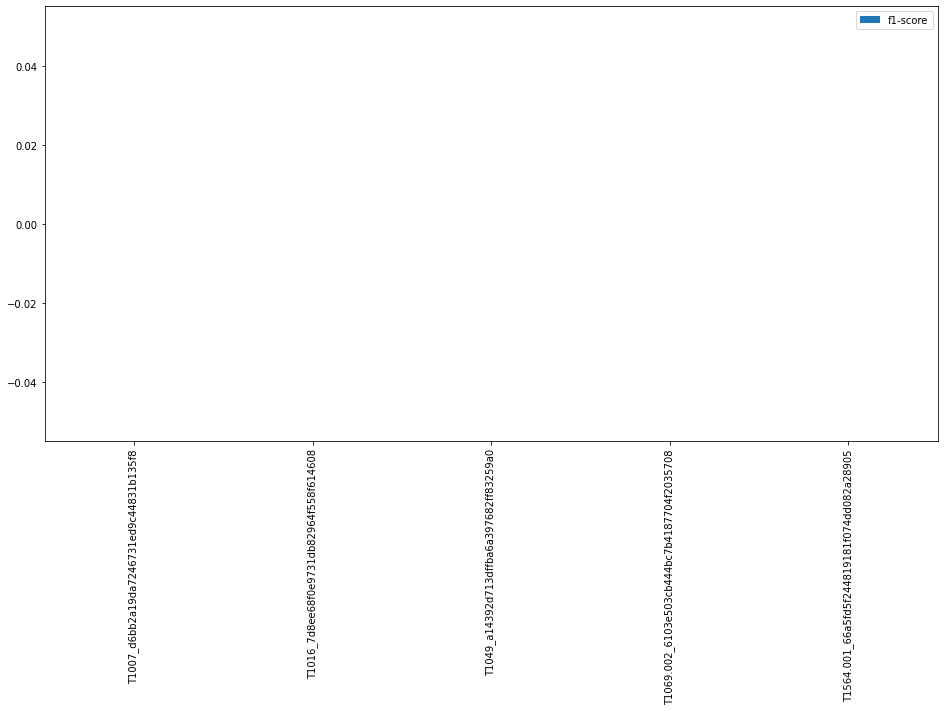

In [25]:
import matplotlib.pyplot as plt

# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()